In [1]:
# dms3.py server must be running

# Database access

In [1]:
import requests
from rich.pretty import pprint
from rich import print_json
import json
B='http://localhost:8080'
DB='dms0'

def get(p,no_show=False,**kw):
    r=requests.get(f'{B}/{p}',params=kw)
    pprint(r)
    data=json.loads(r.text)
    if not no_show: pprint(data)
    return data

# lists database tables (collections)
get(f'{DB}')
# lists objects in one collection
# ID=get(f'{DB}/ConcreteRVE')[-1]

<Response [200]>

[
│   'Beam',
│   'CrossSection',
│   'ConcreteRVE',
│   'CTScan',
│   'BeamState',
│   'CrossSectionState',
│   'ConcreteRVEState',
│   'MaterialRecord'
]

['Beam',
 'CrossSection',
 'ConcreteRVE',
 'CTScan',
 'BeamState',
 'CrossSectionState',
 'ConcreteRVEState',
 'MaterialRecord']

# Getting and setting objects

In [2]:
# POST object from JSON
r=requests.post(
    f'{B}/{DB}/ConcreteRVE',
    json={
        "origin":{"value":[1,2,3],"unit":"mm"},
        "size":{"value":[1,2,3],"unit":"km"},
        "materials":[
            {"name":"mat1","props":{"origin":"CZ"}},
            {"name":"mat2","props":{"origin":"DE"}}
        ],
         "ct":{"id":"bar"} ### bytes not JSON-serializable: "image":bytes(range(70,80))
    }
)
pprint(r)
ID2=json.loads(r.text)
pprint(ID2)
# gets an object (no parent)     
get(f'{DB}/ConcreteRVE/{ID2}');
# limit recursion
get(f'{DB}/ConcreteRVE/{ID2}',max_level=1);
# path will return either a value
get(f'{DB}/ConcreteRVE/{ID2}',path='materials[0].name')
# or an object
get(f'{DB}/ConcreteRVE/{ID2}',path='materials[0]');

<Response [200]>

'6358ec1475bca05db85a4558'

<Response [200]>

{
│   '_meta': {'id': '6358ec1475bca05db85a4558', 'type': 'ConcreteRVE'},
│   'origin': {'value': [0.0010000000474974513, 0.0020000000949949026, 0.003000000026077032], 'unit': 'm'},
│   'size': {'value': [1000000000.0, 2000000000.0, 3000000000.0], 'unit': 'um'},
│   'materials': [
│   │   {
│   │   │   '_meta': {
│   │   │   │   'id': '6358ec1475bca05db85a4555',
│   │   │   │   'type': 'MaterialRecord',
│   │   │   │   'parent': '6358ec1475bca05db85a4558'
│   │   │   },
│   │   │   'name': 'mat1',
│   │   │   'props': {'origin': 'CZ'}
│   │   },
│   │   {
│   │   │   '_meta': {
│   │   │   │   'id': '6358ec1475bca05db85a4556',
│   │   │   │   'type': 'MaterialRecord',
│   │   │   │   'parent': '6358ec1475bca05db85a4558'
│   │   │   },
│   │   │   'name': 'mat2',
│   │   │   'props': {'origin': 'DE'}
│   │   }
│   ],
│   'ct': {
│   │   '_meta': {'id': '6358ec1475bca05db85a4557', 'type': 'CTScan', 'parent': '6358ec1475bca05db85a4558'},
│   │   'id': 'bar'
│   }
}

<Response [200]>

{
│   '_meta': {'id': '6358ec1475bca05db85a4558', 'type': 'ConcreteRVE'},
│   'origin': {'value': [0.0010000000474974513, 0.0020000000949949026, 0.003000000026077032], 'unit': 'm'},
│   'size': {'value': [1000000000.0, 2000000000.0, 3000000000.0], 'unit': 'um'},
│   'materials': [
│   │   {
│   │   │   '_meta': {
│   │   │   │   'id': '6358ec1475bca05db85a4555',
│   │   │   │   'type': 'MaterialRecord',
│   │   │   │   'parent': '6358ec1475bca05db85a4558'
│   │   │   },
│   │   │   'name': 'mat1',
│   │   │   'props': {'origin': 'CZ'}
│   │   },
│   │   {
│   │   │   '_meta': {
│   │   │   │   'id': '6358ec1475bca05db85a4556',
│   │   │   │   'type': 'MaterialRecord',
│   │   │   │   'parent': '6358ec1475bca05db85a4558'
│   │   │   },
│   │   │   'name': 'mat2',
│   │   │   'props': {'origin': 'DE'}
│   │   }
│   ],
│   'ct': {
│   │   '_meta': {'id': '6358ec1475bca05db85a4557', 'type': 'CTScan', 'parent': '6358ec1475bca05db85a4558'},
│   │   'id': 'bar'
│   }
}

<Response [200]>

'mat1'

<Response [200]>

{
│   '_meta': {'id': '6358ec1475bca05db85a4555', 'type': 'MaterialRecord', 'parent': '6358ec1475bca05db85a4558'},
│   'name': 'mat1',
│   'props': {'origin': 'CZ'}
}

# object tracking

Object tracking allows dumps where objects are not duplicated (off by default). Repeated object will cause a special link to be created (dot notation) which will be correctly handles by object POST.

In [3]:
ins={
    "cs":{"rve":{"origin":{"value":[5,5,5],"unit":"mm"},"ct":{"id":"scan-000"},"materials":[{"name":"mat0"},{"name":"mat1"},{"name":"mat2"}]}},
    "csState":[{"rveStates":[{"rve":"..cs.rve"}]}]    # ..cs.rve is a relative link; leading dots ascend
}
pprint(ins)
r=requests.post(
    f'{B}/{DB}/BeamState',
    json=ins
)
pprint(r)
if not r.ok: raise RuntimeError(r)
ID=json.loads(r.text)
get(f'{DB}/BeamState/{ID}');

# tracking will replace repeated objects with relative link which object POST understands
# _meta in IDs will be used to set _meta['upstream_'] in new objects\
dump=get(f'{DB}/BeamState/{ID}',tracking=True);
pprint(dump)
# use the dump to create a new object
r=requests.post(f'{B}/{DB}/BeamState',json=dump)
ID2=json.loads(r.text)
get(f'{DB}/BeamState/{ID2}');

# this is a shortcut for dump with Tracking and POST
ID3=get(f'{DB}/BeamState/{ID2}/clone')
get(f'{DB}/BeamState/{ID3}');


{
│   'cs': {
│   │   'rve': {
│   │   │   'origin': {'value': [5, 5, 5], 'unit': 'mm'},
│   │   │   'ct': {'id': 'scan-000'},
│   │   │   'materials': [{'name': 'mat0'}, {'name': 'mat1'}, {'name': 'mat2'}]
│   │   }
│   },
│   'csState': [{'rveStates': [{'rve': '..cs.rve'}]}]
}

<Response [200]>

<Response [200]>

{
│   '_meta': {'id': '6358ec1575bca05db85a4561', 'type': 'BeamState'},
│   'cs': {
│   │   '_meta': {'id': '6358ec1575bca05db85a455e', 'type': 'CrossSection', 'parent': '6358ec1575bca05db85a4561'},
│   │   'rve': {
│   │   │   '_meta': {
│   │   │   │   'id': '6358ec1575bca05db85a455d',
│   │   │   │   'type': 'ConcreteRVE',
│   │   │   │   'parent': '6358ec1575bca05db85a455e'
│   │   │   },
│   │   │   'origin': {'value': [0.005000000353902578, 0.005000000353902578, 0.005000000353902578], 'unit': 'm'},
│   │   │   'ct': {
│   │   │   │   '_meta': {
│   │   │   │   │   'id': '6358ec1575bca05db85a4559',
│   │   │   │   │   'type': 'CTScan',
│   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   },
│   │   │   │   'id': 'scan-000'
│   │   │   },
│   │   │   'materials': [
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455a',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat0'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455b',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat1'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455c',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat2'
│   │   │   │   }
│   │   │   ]
│   │   }
│   },
│   'csState': [
│   │   {
│   │   │   '_meta': {
│   │   │   │   'id': '6358ec1575bca05db85a4560',
│   │   │   │   'type': 'CrossSectionState',
│   │   │   │   'parent': '6358ec1575bca05db85a4561'
│   │   │   },
│   │   │   'rveStates': [
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455f',
│   │   │   │   │   │   'type': 'ConcreteRVEState',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a4560'
│   │   │   │   │   },
│   │   │   │   │   'rve': {
│   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   'id': '6358ec1575bca05db85a455d',
│   │   │   │   │   │   │   'type': 'ConcreteRVE',
│   │   │   │   │   │   │   'parent': '6358ec1575bca05db85a455f'
│   │   │   │   │   │   },
│   │   │   │   │   │   'origin': {
│   │   │   │   │   │   │   'value': [0.005000000353902578, 0.005000000353902578, 0.005000000353902578],
│   │   │   │   │   │   │   'unit': 'm'
│   │   │   │   │   │   },
│   │   │   │   │   │   'ct': {
│   │   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   │   'id': '6358ec1575bca05db85a4559',
│   │   │   │   │   │   │   │   'type': 'CTScan',
│   │   │   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   │   │   },
│   │   │   │   │   │   │   'id': 'scan-000'
│   │   │   │   │   │   },
│   │   │   │   │   │   'materials': [
│   │   │   │   │   │   │   {
│   │   │   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   │   │   'id': '6358ec1575bca05db85a455a',
│   │   │   │   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   │   │   │   },
│   │   │   │   │   │   │   │   'name': 'mat0'
│   │   │   │   │   │   │   },
│   │   │   │   │   │   │   {
│   │   │   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   │   │   'id': '6358ec1575bca05db85a455b',
│   │   │   │   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   │   │   │   },
│   │   │   │   │   │   │   │   'name': 'mat1'
│   │   │   │   │   │   │   },
│   │   │   │   │   │   │   {
│   │   │   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   │   │   'id': '6358ec1575bca05db85a455c',
│ 

<Response [200]>

{
│   '_meta': {'id': '6358ec1575bca05db85a4561', 'type': 'BeamState'},
│   'cs': {
│   │   '_meta': {'id': '6358ec1575bca05db85a455e', 'type': 'CrossSection', 'parent': '6358ec1575bca05db85a4561'},
│   │   'rve': {
│   │   │   '_meta': {
│   │   │   │   'id': '6358ec1575bca05db85a455d',
│   │   │   │   'type': 'ConcreteRVE',
│   │   │   │   'parent': '6358ec1575bca05db85a455e'
│   │   │   },
│   │   │   'origin': {'value': [0.005000000353902578, 0.005000000353902578, 0.005000000353902578], 'unit': 'm'},
│   │   │   'ct': {
│   │   │   │   '_meta': {
│   │   │   │   │   'id': '6358ec1575bca05db85a4559',
│   │   │   │   │   'type': 'CTScan',
│   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   },
│   │   │   │   'id': 'scan-000'
│   │   │   },
│   │   │   'materials': [
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455a',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat0'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455b',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat1'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455c',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat2'
│   │   │   │   }
│   │   │   ]
│   │   }
│   },
│   'csState': [
│   │   {
│   │   │   '_meta': {
│   │   │   │   'id': '6358ec1575bca05db85a4560',
│   │   │   │   'type': 'CrossSectionState',
│   │   │   │   'parent': '6358ec1575bca05db85a4561'
│   │   │   },
│   │   │   'rveStates': [
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455f',
│   │   │   │   │   │   'type': 'ConcreteRVEState',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a4560'
│   │   │   │   │   },
│   │   │   │   │   'rve': '...cs.rve'
│   │   │   │   }
│   │   │   ]
│   │   }
│   ]
}

{
│   '_meta': {'id': '6358ec1575bca05db85a4561', 'type': 'BeamState'},
│   'cs': {
│   │   '_meta': {'id': '6358ec1575bca05db85a455e', 'type': 'CrossSection', 'parent': '6358ec1575bca05db85a4561'},
│   │   'rve': {
│   │   │   '_meta': {
│   │   │   │   'id': '6358ec1575bca05db85a455d',
│   │   │   │   'type': 'ConcreteRVE',
│   │   │   │   'parent': '6358ec1575bca05db85a455e'
│   │   │   },
│   │   │   'origin': {'value': [0.005000000353902578, 0.005000000353902578, 0.005000000353902578], 'unit': 'm'},
│   │   │   'ct': {
│   │   │   │   '_meta': {
│   │   │   │   │   'id': '6358ec1575bca05db85a4559',
│   │   │   │   │   'type': 'CTScan',
│   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   },
│   │   │   │   'id': 'scan-000'
│   │   │   },
│   │   │   'materials': [
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455a',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat0'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455b',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat1'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455c',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a455d'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat2'
│   │   │   │   }
│   │   │   ]
│   │   }
│   },
│   'csState': [
│   │   {
│   │   │   '_meta': {
│   │   │   │   'id': '6358ec1575bca05db85a4560',
│   │   │   │   'type': 'CrossSectionState',
│   │   │   │   'parent': '6358ec1575bca05db85a4561'
│   │   │   },
│   │   │   'rveStates': [
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'id': '6358ec1575bca05db85a455f',
│   │   │   │   │   │   'type': 'ConcreteRVEState',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a4560'
│   │   │   │   │   },
│   │   │   │   │   'rve': '...cs.rve'
│   │   │   │   }
│   │   │   ]
│   │   }
│   ]
}

<Response [200]>

{
│   '_meta': {'upstream': '6358ec1575bca05db85a4561', 'id': '6358ec1575bca05db85a456a', 'type': 'BeamState'},
│   'cs': {
│   │   '_meta': {
│   │   │   'upstream': '6358ec1575bca05db85a455e',
│   │   │   'id': '6358ec1575bca05db85a4567',
│   │   │   'type': 'CrossSection',
│   │   │   'parent': '6358ec1575bca05db85a456a'
│   │   },
│   │   'rve': {
│   │   │   '_meta': {
│   │   │   │   'upstream': '6358ec1575bca05db85a455d',
│   │   │   │   'id': '6358ec1575bca05db85a4566',
│   │   │   │   'type': 'ConcreteRVE',
│   │   │   │   'parent': '6358ec1575bca05db85a4567'
│   │   │   },
│   │   │   'origin': {'value': [0.0, 0.0, 0.0], 'unit': 'm'},
│   │   │   'ct': {
│   │   │   │   '_meta': {
│   │   │   │   │   'upstream': '6358ec1575bca05db85a4559',
│   │   │   │   │   'id': '6358ec1575bca05db85a4562',
│   │   │   │   │   'type': 'CTScan',
│   │   │   │   │   'parent': '6358ec1575bca05db85a4566'
│   │   │   │   },
│   │   │   │   'id': 'scan-000'
│   │   │   },
│   │   │   'materials': [
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'upstream': '6358ec1575bca05db85a455a',
│   │   │   │   │   │   'id': '6358ec1575bca05db85a4563',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a4566'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat0'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'upstream': '6358ec1575bca05db85a455b',
│   │   │   │   │   │   'id': '6358ec1575bca05db85a4564',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a4566'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat1'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'upstream': '6358ec1575bca05db85a455c',
│   │   │   │   │   │   'id': '6358ec1575bca05db85a4565',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a4566'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat2'
│   │   │   │   }
│   │   │   ]
│   │   }
│   },
│   'csState': [
│   │   {
│   │   │   '_meta': {
│   │   │   │   'upstream': '6358ec1575bca05db85a4560',
│   │   │   │   'id': '6358ec1575bca05db85a4569',
│   │   │   │   'type': 'CrossSectionState',
│   │   │   │   'parent': '6358ec1575bca05db85a456a'
│   │   │   },
│   │   │   'rveStates': [
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'upstream': '6358ec1575bca05db85a455f',
│   │   │   │   │   │   'id': '6358ec1575bca05db85a4568',
│   │   │   │   │   │   'type': 'ConcreteRVEState',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a4569'
│   │   │   │   │   },
│   │   │   │   │   'rve': {
│   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   'upstream': '6358ec1575bca05db85a455d',
│   │   │   │   │   │   │   'id': '6358ec1575bca05db85a4566',
│   │   │   │   │   │   │   'type': 'ConcreteRVE',
│   │   │   │   │   │   │   'parent': '6358ec1575bca05db85a4568'
│   │   │   │   │   │   },
│   │   │   │   │   │   'origin': {'value': [0.0, 0.0, 0.0], 'unit': 'm'},
│   │   │   │   │   │   'ct': {
│   │   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   │   'upstream': '6358ec1575bca05db85a4559',
│   │   │   │   │   │   │   │   'id': '6358ec1575bca05db85a4562',
│   │   │   │   │   │   │   │   'type': 'CTScan',
│   │   │   │   │   │   │   │   'parent': '6358ec1575bca05db85a4566'
│   │   │   │   │   │   │   },
│   │   │   │   │   │   │   'id': 'scan-000'
│   │   │   │   │   │   },
│   │   │   │   │   │   'materials': [
│   │   │   │   │   │   │   {
│   │   │   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   │   │   'upstream': '6358ec1575bca05db85a455a',
│   │   │   │   │   │   │   │   │   'id': '6358ec1575bca05db85a4563',
│   │   │   │   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   │   │   │   'parent': '6358ec1575bca05db85a4566'
│   │   │   │   │   │   │   │   },
│   │   │   │   

<Response [200]>

'6358ec1575bca05db85a4573'

<Response [200]>

{
│   '_meta': {'upstream': '6358ec1575bca05db85a456a', 'id': '6358ec1575bca05db85a4573', 'type': 'BeamState'},
│   'cs': {
│   │   '_meta': {
│   │   │   'upstream': '6358ec1575bca05db85a4567',
│   │   │   'id': '6358ec1575bca05db85a4570',
│   │   │   'type': 'CrossSection',
│   │   │   'parent': '6358ec1575bca05db85a4573'
│   │   },
│   │   'rve': {
│   │   │   '_meta': {
│   │   │   │   'upstream': '6358ec1575bca05db85a4566',
│   │   │   │   'id': '6358ec1575bca05db85a456f',
│   │   │   │   'type': 'ConcreteRVE',
│   │   │   │   'parent': '6358ec1575bca05db85a4570'
│   │   │   },
│   │   │   'origin': {'value': [0.0, 0.0, 0.0], 'unit': 'm'},
│   │   │   'ct': {
│   │   │   │   '_meta': {
│   │   │   │   │   'upstream': '6358ec1575bca05db85a4562',
│   │   │   │   │   'id': '6358ec1575bca05db85a456b',
│   │   │   │   │   'type': 'CTScan',
│   │   │   │   │   'parent': '6358ec1575bca05db85a456f'
│   │   │   │   },
│   │   │   │   'id': 'scan-000'
│   │   │   },
│   │   │   'materials': [
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'upstream': '6358ec1575bca05db85a4563',
│   │   │   │   │   │   'id': '6358ec1575bca05db85a456c',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a456f'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat0'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'upstream': '6358ec1575bca05db85a4564',
│   │   │   │   │   │   'id': '6358ec1575bca05db85a456d',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a456f'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat1'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'upstream': '6358ec1575bca05db85a4565',
│   │   │   │   │   │   'id': '6358ec1575bca05db85a456e',
│   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a456f'
│   │   │   │   │   },
│   │   │   │   │   'name': 'mat2'
│   │   │   │   }
│   │   │   ]
│   │   }
│   },
│   'csState': [
│   │   {
│   │   │   '_meta': {
│   │   │   │   'upstream': '6358ec1575bca05db85a4569',
│   │   │   │   'id': '6358ec1575bca05db85a4572',
│   │   │   │   'type': 'CrossSectionState',
│   │   │   │   'parent': '6358ec1575bca05db85a4573'
│   │   │   },
│   │   │   'rveStates': [
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'upstream': '6358ec1575bca05db85a4568',
│   │   │   │   │   │   'id': '6358ec1575bca05db85a4571',
│   │   │   │   │   │   'type': 'ConcreteRVEState',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a4572'
│   │   │   │   │   },
│   │   │   │   │   'rve': {
│   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   'upstream': '6358ec1575bca05db85a4566',
│   │   │   │   │   │   │   'id': '6358ec1575bca05db85a456f',
│   │   │   │   │   │   │   'type': 'ConcreteRVE',
│   │   │   │   │   │   │   'parent': '6358ec1575bca05db85a4571'
│   │   │   │   │   │   },
│   │   │   │   │   │   'origin': {'value': [0.0, 0.0, 0.0], 'unit': 'm'},
│   │   │   │   │   │   'ct': {
│   │   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   │   'upstream': '6358ec1575bca05db85a4562',
│   │   │   │   │   │   │   │   'id': '6358ec1575bca05db85a456b',
│   │   │   │   │   │   │   │   'type': 'CTScan',
│   │   │   │   │   │   │   │   'parent': '6358ec1575bca05db85a456f'
│   │   │   │   │   │   │   },
│   │   │   │   │   │   │   'id': 'scan-000'
│   │   │   │   │   │   },
│   │   │   │   │   │   'materials': [
│   │   │   │   │   │   │   {
│   │   │   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   │   │   'upstream': '6358ec1575bca05db85a4563',
│   │   │   │   │   │   │   │   │   'id': '6358ec1575bca05db85a456c',
│   │   │   │   │   │   │   │   │   'type': 'MaterialRecord',
│   │   │   │   │   │   │   │   │   'parent': '6358ec1575bca05db85a456f'
│   │   │   │   │   │   │   │   },
│   │   │   │   

# Shallow clones

* We build directed link graph for each top object.
* Given all dot-notation paths of attributes that will be modified (workflow will know this in advance), we can determine which parts of the graph (database objects) can be only linked (shallow copy) when cloning the top-level object.
* We use the `nextworx` module for this.
* See the next cell for visualization, where `ConcreteRVE` will me modified, thus all paths leading to it must be deep-copied:

  - green is the top-level object (always deep-copied)
  - cyan nodes will be deep-copied
  - red nodes will have shallow copy only
  

<Response [200]>

[
│   [
│   │   'MaterialRecord\n6358ec1575bca05db85a456c',
│   │   'ConcreteRVEState\n6358ec1575bca05db85a4571',
│   │   'BeamState\n6358ec1575bca05db85a4573',
│   │   'CrossSectionState\n6358ec1575bca05db85a4572',
│   │   'MaterialRecord\n6358ec1575bca05db85a456e',
│   │   'CTScan\n6358ec1575bca05db85a456b',
│   │   'CrossSection\n6358ec1575bca05db85a4570',
│   │   'MaterialRecord\n6358ec1575bca05db85a456d',
│   │   'ConcreteRVE\n6358ec1575bca05db85a456f'
│   ],
│   [
│   │   ['ConcreteRVE\n6358ec1575bca05db85a456f', 'MaterialRecord\n6358ec1575bca05db85a456c'],
│   │   ['CrossSection\n6358ec1575bca05db85a4570', 'ConcreteRVE\n6358ec1575bca05db85a456f'],
│   │   ['ConcreteRVE\n6358ec1575bca05db85a456f', 'MaterialRecord\n6358ec1575bca05db85a456d'],
│   │   ['BeamState\n6358ec1575bca05db85a4573', 'CrossSection\n6358ec1575bca05db85a4570'],
│   │   ['ConcreteRVE\n6358ec1575bca05db85a456f', 'CTScan\n6358ec1575bca05db85a456b'],
│   │   ['ConcreteRVE\n6358ec1575bca05db85a456f', 'MaterialRecord\n6358ec1575bca05db85a456e'],
│   │   ['BeamState\n6358ec1575bca05db85a4573', 'CrossSectionState\n6358ec1575bca05db85a4572'],
│   │   ['CrossSectionState\n6358ec1575bca05db85a4572', 'ConcreteRVEState\n6358ec1575bca05db85a4571'],
│   │   ['ConcreteRVEState\n6358ec1575bca05db85a4571', 'ConcreteRVE\n6358ec1575bca05db85a456f']
│   ]
]

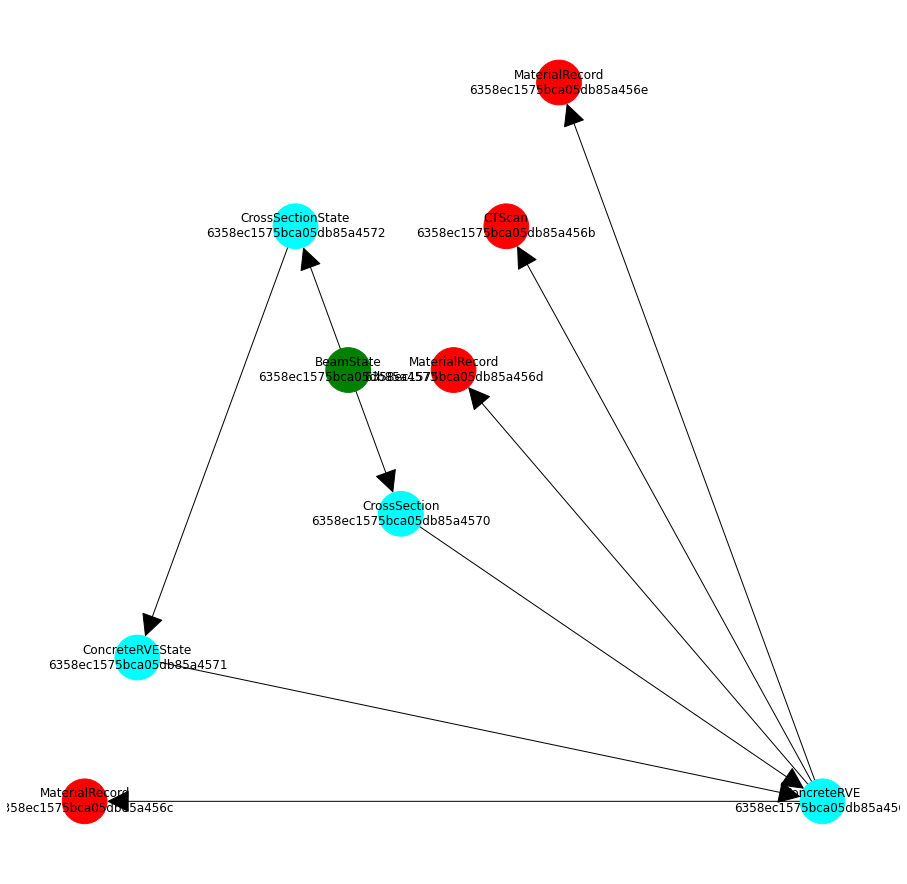

In [4]:
# this normally happens inside {db}/{type}/{id}/safe-links endpoint

# debug will prepend class name to the ID, for readability
nodes,edges=get(f'{DB}/BeamState/{ID3}/graph',debug=True)
import networkx as nx
import matplotlib.pyplot as plt
G=nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
assert nx.is_weakly_connected(G)

# 
root=[n for n in nodes if n.startswith('BeamState')][0]
mod=[n for n in nodes if n.startswith('ConcreteRVE\n')][0]
ppp=[nx.all_simple_paths(G,root,mod)]
seen=set()
for pp in ppp:
    for p in pp: seen.update(p)
def n_c(n):
    if n.startswith('BeamState'): return 'green'
    if n in seen: return 'cyan'
    return 'red'
fig,ax=plt.subplots(1,1,figsize=(16,16))
nx.draw(
    G,ax=ax,with_labels=True,
    node_size=2000,
    pos=nx.planar_layout(G),
    arrowsize=50,
    node_color=[n_c(n) for n in G.nodes]
)

## API

* obtain `safe-links` (name to be changed) from an object, given all dot-notation paths for modifications
* passing `shallow` to object getter to check that only IDs are put for shallow objects
* feed list of `safe-links` to `clone` so that it will skip these (and all descending, by defnition) objects during deep-copy
* check that clone respects shallow objects


In [5]:
# debug shows nodes with class names
# FIXME: paths are space-separated for now
get(f'{DB}/BeamState/{ID3}/safe-links',paths='cs.rve',debug=True)
ss=get(f'{DB}/BeamState/{ID3}/safe-links',paths='cs.rve')
shallow=' '.join(ss)
print(ss)

# dump object, verify that e.g. the CT was not deep-copied in the dump
s=get(f'{DB}/BeamState/{ID3}',shallow=shallow);
assert isinstance(s['cs']['rve']['ct'],str)

## creates a new obejct in the DB, using shallow objects
ID4=get(f'{DB}/BeamState/{ID3}/clone',shallow=shallow);

orig=get(f'{DB}/BeamState/{ID3}',path='cs.rve.ct')
clone=get(f'{DB}/BeamState/{ID4}',path='cs.rve.ct')

## verify that IDs are the same but parents different (parents are create on-the fly)
assert orig['_meta']['id']==clone['_meta']['id']
assert orig['_meta']['parent']!=clone['_meta']['parent']
assert orig['_meta']['upstream']==clone['_meta']['upstream']

<Response [200]>

[
│   'MaterialRecord\n6358ec1575bca05db85a456c',
│   'MaterialRecord\n6358ec1575bca05db85a456d',
│   'MaterialRecord\n6358ec1575bca05db85a456e',
│   'CTScan\n6358ec1575bca05db85a456b'
]

<Response [200]>

['6358ec1575bca05db85a456d', '6358ec1575bca05db85a456c', '6358ec1575bca05db85a456b', '6358ec1575bca05db85a456e']

['6358ec1575bca05db85a456d', '6358ec1575bca05db85a456c', '6358ec1575bca05db85a456b', '6358ec1575bca05db85a456e']


<Response [200]>

{
│   '_meta': {'upstream': '6358ec1575bca05db85a456a', 'id': '6358ec1575bca05db85a4573', 'type': 'BeamState'},
│   'cs': {
│   │   '_meta': {
│   │   │   'upstream': '6358ec1575bca05db85a4567',
│   │   │   'id': '6358ec1575bca05db85a4570',
│   │   │   'type': 'CrossSection',
│   │   │   'parent': '6358ec1575bca05db85a4573'
│   │   },
│   │   'rve': {
│   │   │   '_meta': {
│   │   │   │   'upstream': '6358ec1575bca05db85a4566',
│   │   │   │   'id': '6358ec1575bca05db85a456f',
│   │   │   │   'type': 'ConcreteRVE',
│   │   │   │   'parent': '6358ec1575bca05db85a4570'
│   │   │   },
│   │   │   'origin': {'value': [0.0, 0.0, 0.0], 'unit': 'm'},
│   │   │   'ct': '6358ec1575bca05db85a456b',
│   │   │   'materials': ['6358ec1575bca05db85a456c', '6358ec1575bca05db85a456d', '6358ec1575bca05db85a456e']
│   │   }
│   },
│   'csState': [
│   │   {
│   │   │   '_meta': {
│   │   │   │   'upstream': '6358ec1575bca05db85a4569',
│   │   │   │   'id': '6358ec1575bca05db85a4572',
│   │   │   │   'type': 'CrossSectionState',
│   │   │   │   'parent': '6358ec1575bca05db85a4573'
│   │   │   },
│   │   │   'rveStates': [
│   │   │   │   {
│   │   │   │   │   '_meta': {
│   │   │   │   │   │   'upstream': '6358ec1575bca05db85a4568',
│   │   │   │   │   │   'id': '6358ec1575bca05db85a4571',
│   │   │   │   │   │   'type': 'ConcreteRVEState',
│   │   │   │   │   │   'parent': '6358ec1575bca05db85a4572'
│   │   │   │   │   },
│   │   │   │   │   'rve': {
│   │   │   │   │   │   '_meta': {
│   │   │   │   │   │   │   'upstream': '6358ec1575bca05db85a4566',
│   │   │   │   │   │   │   'id': '6358ec1575bca05db85a456f',
│   │   │   │   │   │   │   'type': 'ConcreteRVE',
│   │   │   │   │   │   │   'parent': '6358ec1575bca05db85a4571'
│   │   │   │   │   │   },
│   │   │   │   │   │   'origin': {'value': [0.0, 0.0, 0.0], 'unit': 'm'},
│   │   │   │   │   │   'ct': '6358ec1575bca05db85a456b',
│   │   │   │   │   │   'materials': [
│   │   │   │   │   │   │   '6358ec1575bca05db85a456c',
│   │   │   │   │   │   │   '6358ec1575bca05db85a456d',
│   │   │   │   │   │   │   '6358ec1575bca05db85a456e'
│   │   │   │   │   │   ]
│   │   │   │   │   }
│   │   │   │   }
│   │   │   ]
│   │   }
│   ]
}

<Response [200]>

'6358ec1775bca05db85a4578'

<Response [200]>

{
│   '_meta': {
│   │   'upstream': '6358ec1575bca05db85a4562',
│   │   'id': '6358ec1575bca05db85a456b',
│   │   'type': 'CTScan',
│   │   'parent': '6358ec1575bca05db85a4570'
│   },
│   'id': 'scan-000'
}

<Response [200]>

{
│   '_meta': {
│   │   'upstream': '6358ec1575bca05db85a4562',
│   │   'id': '6358ec1575bca05db85a456b',
│   │   'type': 'CTScan',
│   │   'parent': '6358ec1775bca05db85a4575'
│   },
│   'id': 'scan-000'
}

## Attribute modification
Use PATCH method on object to set a path. Example below. Patch data is packed into dictionary `{'path':'...','data':{...}}`.


In [6]:
import astropy.units as au
from astropy.units import Quantity
rec=get(f'{DB}/BeamState/{ID4}',path='cs.rve.origin')
q=Quantity(**rec)
q+=[1,1,1]*au.m
print(q)

pprint(ins)
r=requests.patch(
    f'{B}/{DB}/BeamState/{ID4}',
    data=json.dumps({'path':'cs.rve.origin','data':{'value':q.value.tolist(),'unit':str(q.unit)}})
)
if not r.ok: raise RuntimeError(r)

rec2=get(f'{DB}/BeamState/{ID4}',path='cs.rve.origin')
assert rec!=rec2


<Response [200]>

{'value': [0.0, 0.0, 0.0], 'unit': 'm'}

[1. 1. 1.] m


{
│   'cs': {
│   │   'rve': {
│   │   │   'origin': {'value': [5, 5, 5], 'unit': 'mm'},
│   │   │   'ct': {'id': 'scan-000'},
│   │   │   'materials': [{'name': 'mat0'}, {'name': 'mat1'}, {'name': 'mat2'}]
│   │   }
│   },
│   'csState': [{'rveStates': [{'rve': '..cs.rve'}]}]
}

<Response [200]>

{'value': [1.0, 1.0, 1.0], 'unit': 'm'}